In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8,5)})

In [92]:
df = pd.read_csv("./HPC_project_run_data - Risposte del google form.csv")

In [3]:
df.columns

Index(['Informazioni cronologiche', 'Run Status', 'Job Codename',
       'Minimum Distance', 'Cluster job ID', 'Input size',
       'Reading time (seconds)', 'Scattering time (seconds)', 'Submitted on',
       'Github commit SHA', 'Github commit author', 'Output from process 0',
       'Number of CPUs', 'Number of Nodes', 'GB of memory',
       'Maximum duration (minutes)', 'Total run time (seconds)',
       'Placing strategy', 'Bechmark name'],
      dtype='object')

In [93]:
df.drop(df[~df['Run Status'].str.contains("successfully")].index, inplace=True)
df["N processes"] = df["Number of CPUs"] * df["Number of Nodes"]
df = df.astype({"N processes":'str'})

In [80]:
df.head()


,Informazioni cronologiche,Run Status,Job Codename,Minimum Distance,Cluster job ID,Input size,Reading time (seconds),Scattering time (seconds),Submitted on,Github commit SHA,Github commit author,Output from process 0,Number of CPUs,Number of Nodes,GB of memory,Maximum duration (minutes),Total run time (seconds),Placing strategy,Bechmark name,N processes
0,10/01/2023 14.54.31,Finished successfully 🧸,NaN,2.0,9124065.hpc-head-n1.unitn.it,100K,0.028530,0.000393,Tue Jan 10 14:54:18 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,civts,Process 0\nLoaded and sorted 100000 points\nRe...,1,1,1,2,0.121677,pack,fitting-lizard,1
1,10/01/2023 14.54.44,Finished successfully 🧸,NaN,2.0,9124066.hpc-head-n1.unitn.it,100K,0.023864,0.000412,Tue Jan 10 14:54:31 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,civts,Process 0\nLoaded and sorted 100000 points\nRe...,1,1,1,2,0.115997,scatter,fitting-lizard,1
2,10/01/2023 14.54.57,Finished successfully 🧸,NaN,2.0,9124068.hpc-head-n1.unitn.it,100K,0.198813,0.000494,Tue Jan 10 14:54:43 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,civts,Process 0\nLoaded and sorted 100000 points\nRe...,1,1,1,2,0.438372,pack:excl,fitting-lizard,1
3,10/01/2023 14.55.09,Finished successfully 🧸,NaN,2.0,9124069.hpc-head-n1.unitn.it,100K,0.024182,0.000694,Tue Jan 10 14:54:56 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,civts,Process 0\nLoaded and sorted 100000 points\nRe...,1,1,1,2,0.11368,scatter:excl,fitting-lizard,1
4,10/01/2023 14.55.23,Finished successfully 🧸,NaN,2.0,9124070.hpc-head-n1.unitn.it,100K,0.518587,0.004087,Tue Jan 10 14:55:09 CET 2023,d5a17e1d5179afbe104f7c63fbdc6ce293e3b4ef,civts,Process 0\nLoaded and sorted 100000 points\nRe...,1,2,1,2,0.791909,pack,fitting-lizard,2


In [105]:
def plot_time_by_n_processes_and_placing_strategy(df):
  df_pack = df[df['Placing strategy'] == 'pack']
  df_scatter = df[df['Placing strategy'] == 'scatter']
  df_pack_excl = df[df['Placing strategy'] == 'pack:excl']
  df_scatter_excl = df[df['Placing strategy'] == 'scatter:excl']

  ticks = list(df_scatter['N processes'].unique())
  plt.xticks(range(0,len(ticks)), ticks)

  sns.lineplot(data=df_pack, x='N processes', y='Total run time (seconds)', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title='Pack strategy')
  plt.show()

  sns.lineplot(data=df_scatter, x='N processes', y='Total run time (seconds)', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title='Scatter strategy')
  plt.show()

  sns.lineplot(data=df_pack_excl, x='N processes', y='Total run time (seconds)', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title='Pack:excl strategy')
  plt.show()

  sns.lineplot(data=df_scatter_excl, x='N processes', y='Total run time (seconds)', hue='Input size', palette='tab10', errorbar=None, marker="o").set(title='scatter:excl strategy')
  plt.show()
  

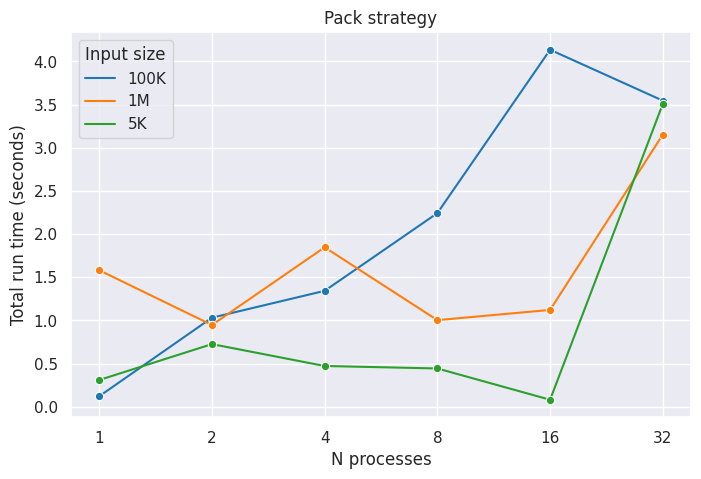

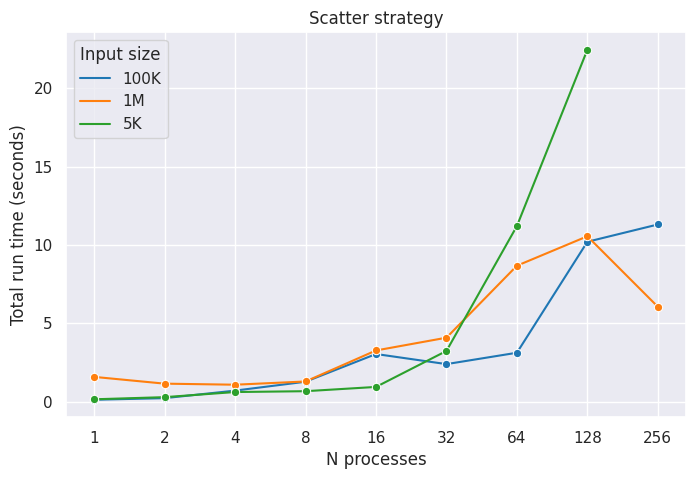

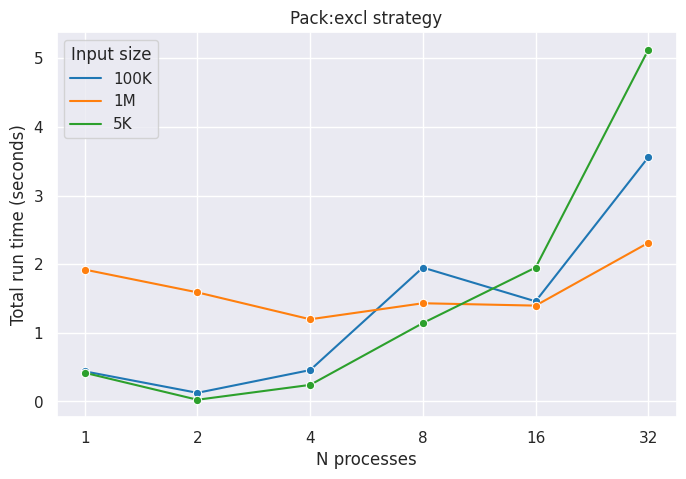

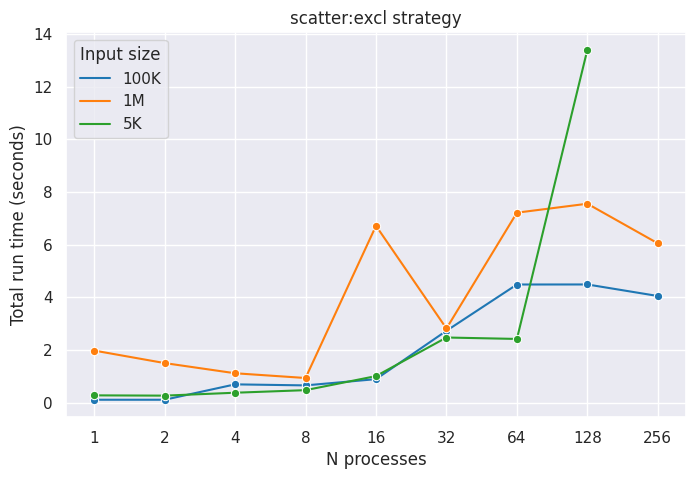

In [106]:
plot_time_by_n_processes_and_placing_strategy(df)